In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


In [ ]:
df_train = pd.read_csv('/content/news_train.csv')
df_valid = pd.read_csv('/content/news_valid.csv')
df_test = pd.read_csv('/content/news_test.csv')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29167 entries, 0 to 29166
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  29167 non-null  object
 1   label     29167 non-null  object
dtypes: object(2)
memory usage: 455.9+ KB


In [ ]:
df_test.size

6586

In [ ]:
df_train.head()

,headline,label
0,Samsung Galaxy M30s: ಲಭ್ಯವಾಗಲಿದೆ ಶಕ್ತಿಶಾಲಿ ಸ್ಮ...,tech
1,ಯುವೆಂಟಸ್ ತಂಡ ಸೇರಿದ ಕ್ರಿಸ್ಟಿಯಾನೊ ರೊನಾಲ್ಡೊ\nಯುವೆ...,sports
2,"ಬ್ಯಾಡ್ಮಿಂಟನ್‌: ಎರಡನೇ ಸುತ್ತಿಗೆ ಸಿಂಧು, ಸಮೀರ್‌\nಬ...",sports
3,ತಮ್ಮದು ಒಪ್ಪಿತ ʼಸಂಬಂಧʼ ಎಂದು ಹೇಳಿದ ನಟ\n 12-05-2...,entertainment
4,ಖ್ಯಾತ ಕ್ರಿಕೆಟಿಗನ ಪತ್ನಿ ನಿಧನ\n 31-12-2018 7:57...,sports


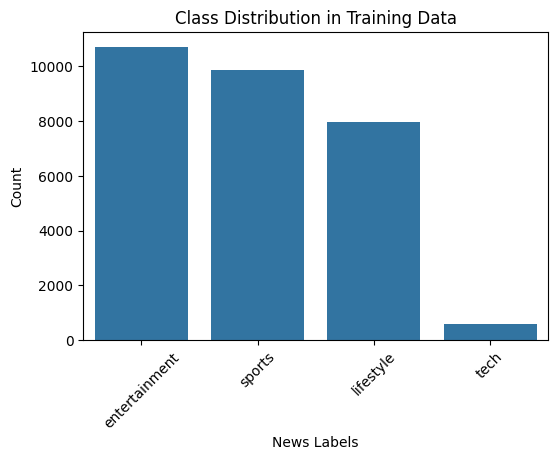

In [ ]:
# Class Distribution Plot
plt.figure(figsize=(6, 4))
sns.countplot(data=df_train, x='label', order=df_train['label'].value_counts().index)
plt.title('Class Distribution in Training Data')
plt.xlabel('News Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Load Stopwords
with open('/content/stop-words.txt', 'r', encoding='utf-8') as f:
    stopwords = set(f.read().splitlines())

In [ ]:
# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\u0C80-\u0CFF\s]', '', text)  # Keep alphanumeric and Kannada characters
    text = ' '.join([word for word in text.split() if word not in stopwords])  # Remove stopwords
    return text

In [ ]:
df_train['headline'] = df_train['headline'].apply(preprocess_text)
df_valid['headline'] = df_valid['headline'].apply(preprocess_text)
df_test['headline'] = df_test['headline'].apply(preprocess_text)

In [ ]:
# Tokenization and Model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,                                   
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',                    #Tokenizes the text using tokenizer.encode_plus, which handles:
                                                    #Adding special tokens ([CLS], [SEP]).
                                                    #Padding/truncating sequences to a fixed length (max_len).
                                                    #Generating attention masks (1 for real tokens, 0 for padding).
                                                    #Returns the tokenized inputs (input_ids, attention_mask) and the label as tensors.
        ) 

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
label_mapping = {label: idx for idx, label in enumerate(df_train['label'].unique())}
df_train['label'] = df_train['label'].map(label_mapping)
df_valid['label'] = df_valid['label'].map(label_mapping)
df_test['label'] = df_test['label'].map(label_mapping)

In [ ]:
train_data = NewsDataset(df_train['headline'].tolist(), df_train['label'].tolist(), tokenizer)
valid_data = NewsDataset(df_valid['headline'].tolist(), df_valid['label'].tolist(), tokenizer)
test_data = NewsDataset(df_test['headline'].tolist(), df_test['label'].tolist(), tokenizer)

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)  
#Creates PyTorch DataLoader objects for batching and shuffling datasets during training and evaluation.

In [ ]:
# Model Definition
class NewsClassifier(nn.Module):
    def __init__(self, distilbert_model, n_classes):
        super(NewsClassifier, self).__init__()
        self.distilbert = distilbert_model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.distilbert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state
        pooled_output = hidden_state[:, 0]  # Take the [CLS] token output
        output = self.drop(pooled_output)
        return self.out(output)

model = NewsClassifier(distilbert_model, n_classes=len(label_mapping))

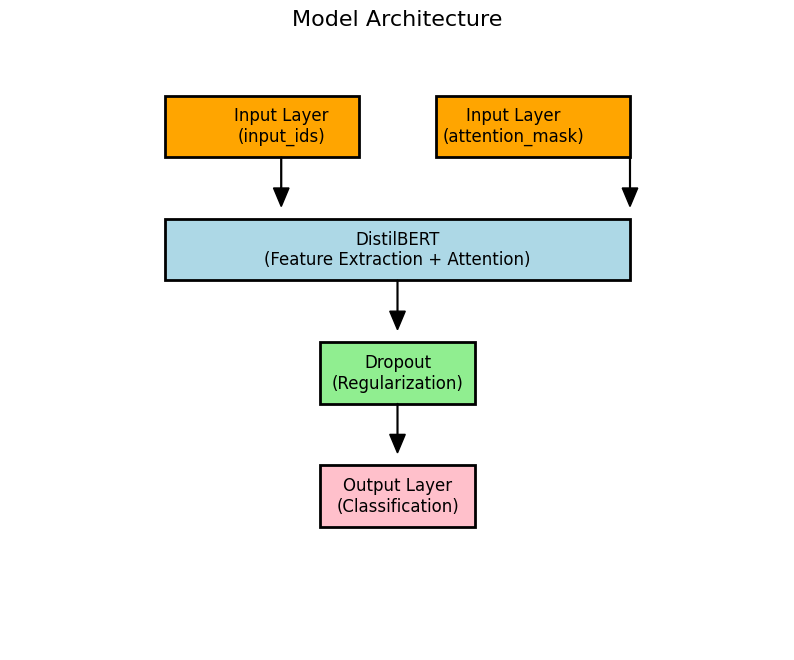

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_model_architecture():
    plt.figure(figsize=(10, 8))
    plt.title('Model Architecture', fontsize=16)

    # Create patches for the layers and components
    input_layer_ids = patches.Rectangle((0.2, 0.8), 0.25, 0.1, edgecolor='black', facecolor='orange', lw=2)
    input_layer_mask = patches.Rectangle((0.55, 0.8), 0.25, 0.1, edgecolor='black', facecolor='orange', lw=2)
    distilbert_layer = patches.Rectangle((0.2, 0.6), 0.6, 0.1, edgecolor='black', facecolor='lightblue', lw=2)
    dropout_layer = patches.Rectangle((0.4, 0.4), 0.2, 0.1, edgecolor='black', facecolor='lightgreen', lw=2)
    output_layer = patches.Rectangle((0.4, 0.2), 0.2, 0.1, edgecolor='black', facecolor='pink', lw=2)

    # Add patches to the plot
    ax = plt.gca()
    ax.add_patch(input_layer_ids)
    ax.add_patch(input_layer_mask)
    ax.add_patch(distilbert_layer)
    ax.add_patch(dropout_layer)
    ax.add_patch(output_layer)

    # Annotate the layers
    plt.text(0.35, 0.85, 'Input Layer\n(input_ids)', fontsize=12, ha='center', va='center')
    plt.text(0.65, 0.85, 'Input Layer\n(attention_mask)', fontsize=12, ha='center', va='center')
    plt.text(0.5, 0.65, 'DistilBERT\n(Feature Extraction + Attention)', fontsize=12, ha='center', va='center')
    plt.text(0.5, 0.45, 'Dropout\n(Regularization)', fontsize=12, ha='center', va='center')
    plt.text(0.5, 0.25, 'Output Layer\n(Classification)', fontsize=12, ha='center', va='center')

    # Draw arrows
    plt.arrow(0.35, 0.8, 0, -0.05, head_width=0.02, head_length=0.03, fc='black', ec='black')
    plt.arrow(0.8, 0.8, 0, -0.05, head_width=0.02, head_length=0.03, fc='black', ec='black')
    plt.arrow(0.5, 0.6, 0, -0.05, head_width=0.02, head_length=0.03, fc='black', ec='black')
    plt.arrow(0.5, 0.4, 0, -0.05, head_width=0.02, head_length=0.03, fc='black', ec='black')

    # Set limits and hide axes
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.show()

# Call the function to plot the updated model architecture
plot_model_architecture()



In [ ]:
# Training and Evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    correct_predictions = 0
    total_loss = 0

    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return correct_predictions.double() / len(data_loader.dataset), total_loss / len(data_loader)

In [ ]:
def eval_model(model, data_loader, criterion, device):
    model.eval()
    correct_predictions = 0
    total_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            total_loss += loss.item()

    return correct_predictions.double() / len(data_loader.dataset), total_loss / len(data_loader)

In [ ]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

In [ ]:
# Training Loop
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    train_acc_list.append(train_acc.item())
    train_loss_list.append(train_loss)
    print(f"Train loss {train_loss}, accuracy {train_acc}")

    val_acc, val_loss = eval_model(model, valid_loader, criterion, device)
    val_acc_list.append(val_acc.item())
    val_loss_list.append(val_loss)
    print(f"Validation loss {val_loss}, accuracy {val_acc}")

Epoch 1/5


100%|██████████| 912/912 [15:25<00:00,  1.01s/it]


Train loss 0.23730893832020739, accuracy 0.9103438817842082
Validation loss 0.12748197734355926, accuracy 0.954
Epoch 2/5


100%|██████████| 912/912 [15:28<00:00,  1.02s/it]


Train loss 0.10784141175686832, accuracy 0.9621490040113827
Validation loss 0.08813012699037791, accuracy 0.9675
Epoch 3/5


100%|██████████| 912/912 [15:33<00:00,  1.02s/it]


Train loss 0.0733483675244395, accuracy 0.9731888778413961
Validation loss 0.09046041843295097, accuracy 0.96725
Epoch 4/5


100%|██████████| 912/912 [15:34<00:00,  1.02s/it]


Train loss 0.05399851373735337, accuracy 0.9798745157198203
Validation loss 0.09687195586506277, accuracy 0.96525
Epoch 5/5


100%|██████████| 912/912 [15:56<00:00,  1.05s/it]


Train loss 0.04378025851129726, accuracy 0.9837144718346076
Validation loss 0.09395988931320608, accuracy 0.969


In [ ]:
# Testing and Report
test_acc, _ = eval_model(model, test_loader, criterion, device)
print(f"Test Accuracy: {test_acc}")

# Classification Report
all_preds, all_labels = [], []

Test Accuracy: 0.9665958092924385


In [ ]:
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
print("Number of Predictions:", len(all_preds))
print("Number of True Labels:", len(all_labels))
print("Sample Predictions:", all_preds[:10])
print("Sample True Labels:", all_labels[:10])

Number of Predictions: 3293
Number of True Labels: 3293
Sample Predictions: [3, 2, 2, 1, 1, 1, 1, 3, 3, 2]
Sample True Labels: [2, 2, 2, 1, 1, 1, 1, 3, 3, 2]


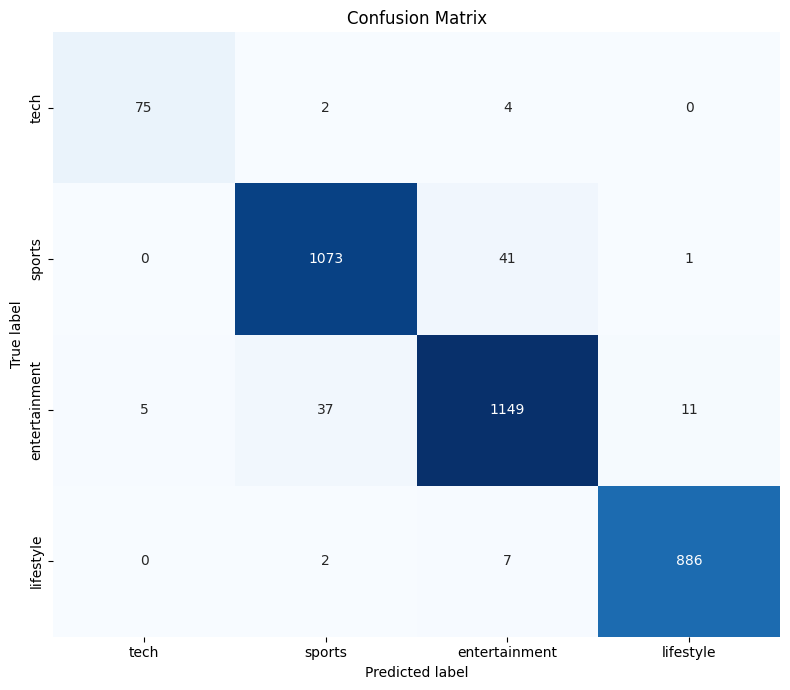

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)

classes = label_mapping.keys()

# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=classes, yticklabels=classes,
                cbar=False)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_confusion_matrix(cm, classes)

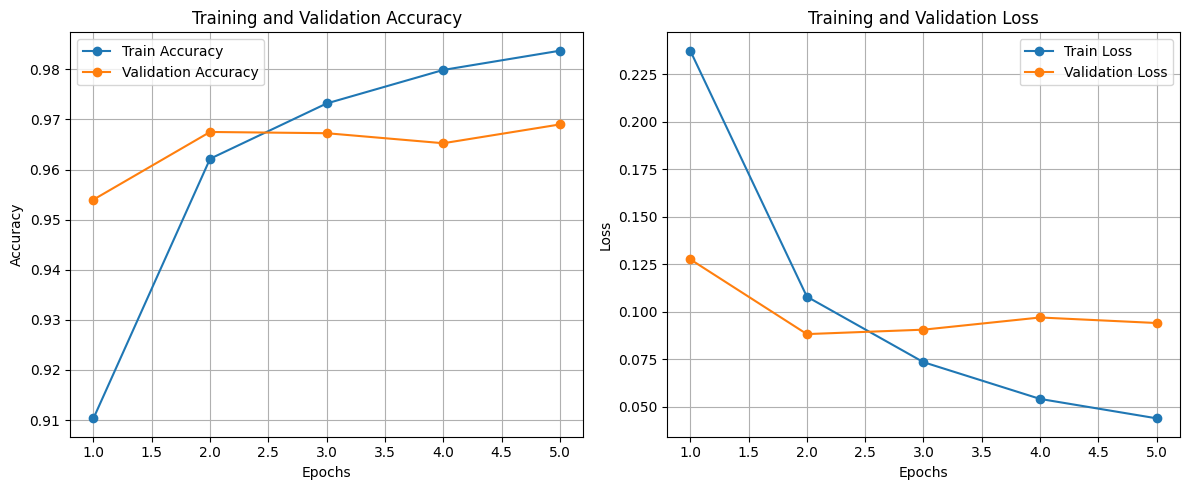

In [ ]:
# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_acc_list, label='Train Accuracy', marker='o')
plt.plot(range(1, epochs + 1), val_acc_list, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(all_labels, all_preds, target_names=label_mapping.keys()))

               precision    recall  f1-score   support

         tech       0.94      0.93      0.93        81
       sports       0.96      0.96      0.96      1115
entertainment       0.96      0.96      0.96      1202
    lifestyle       0.99      0.99      0.99       895

     accuracy                           0.97      3293
    macro avg       0.96      0.96      0.96      3293
 weighted avg       0.97      0.97      0.97      3293



In [ ]:
unseen_news = (
    "ಭಾರತ ಬಿಡುತ್ತೇವೆ ಹೊರತು ನಿಮ್ಮ ನಿಯಮ ಪಾಲಿಸಲು ಆಗುವುದಿಲ್ಲ ಎಂದ ವಾಟ್ಸಾಪ್‌: ಹಾಗಿದ್ರೆ ವಾಟ್ಸಾಪ್‌ ದೇಶ ಬಿಡುತ್ತಾ?"
)

In [ ]:
def predict_news_class(news_text):
    # Tokenize the input text
    inputs = tokenizer(news_text, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Move inputs to the same device as the model
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # prediction
    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])

    # Get the predicted class
    predicted_class_index = torch.argmax(outputs, dim=1).item()

    # Map index to class label
    predicted_class = list(label_mapping.keys())[predicted_class_index]

    return predicted_class

In [ ]:
# Predict the class of the unseen news
predicted_class = predict_news_class(unseen_news)
print(f"The predicted class for the given news article is: {predicted_class}")

The predicted class for the given news article is: tech


The model correctly predicted the "Tech" class.